# # Modelagem

In [1]:
import keras as K
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
if PHYS_DEVICE_NAME:
    print(PHYS_DEVICE_NAME)
else:
    raise Exception('GPU não encontrada')

GPU:0


2023-03-16 01:40:04.173098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:40:04.195015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 01:40:04.195240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dados

In [3]:
!ls DATAFRAMES/

Xfusao.csv  Xmfcc.csv


Iremos organizar os conjuntos a serem utilizados, onde:

- $X$ é formado pelos dados de entrada, que representam os arquivos de áudio;
- $Y$ é formado pelas emoções;
- $Z$ é formado pelas intensidades

In [4]:
X = pd.read_csv('DATAFRAMES/Xmfcc.csv', sep=';')
X.shape

(1364, 120)

In [5]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-264.792786,125.539139,-62.624714,28.315695,1.279387,-8.616631,-4.265706,12.050941,-27.621435,-7.861643,...,-1.748398,-0.898110,-0.119338,0.555444,0.690031,0.893465,0.846773,0.283752,-0.185898,-0.130898
1,-272.888550,121.097145,-41.149326,36.463421,7.565406,-16.098637,-6.408170,3.941464,-18.141294,-10.447558,...,-1.295892,-0.857775,-0.163954,0.522544,0.864576,0.903463,0.971885,0.158906,0.127875,0.256920
2,-252.119629,140.533325,-48.734734,25.311930,11.052135,-15.032625,-15.175117,-0.740196,-12.050269,-6.450643,...,-1.269958,-0.506434,0.136597,0.658416,1.204028,1.187821,1.145636,0.580611,0.591504,0.303071
3,-301.812012,115.630440,-44.689743,40.499535,12.119360,-9.788790,-14.219805,6.883999,-16.215971,-5.742364,...,-1.433162,-0.537758,-0.466619,0.289152,0.665391,0.794946,0.723460,1.131353,0.772526,-0.120861
4,-256.258118,118.041618,-61.199539,42.643768,14.546075,-13.713741,-13.657145,7.992791,-25.783739,-8.232481,...,-0.783558,-0.262848,-0.175987,0.290252,0.595873,1.549510,1.445828,0.597592,0.366670,0.384863


In [6]:
Y = pd.read_csv('DATAFRAMES/Xfusao.csv', sep=';')
Y.drop(labels=['path', 'pessoa', 'genero', 'duracao'], axis=1, inplace=True)
Y.shape

(1364, 4)

In [7]:
Y.tail()

,dataset,arquivo,emocao,intensidade
1359,vivae,S11_surprise_low_03.wav,surpresa,fraca
1360,vivae,S11_surprise_moderate_01.wav,surpresa,moderada
1361,vivae,S11_surprise_peak_04.wav,surpresa,pico
1362,vivae,S11_surprise_strong_011.wav,surpresa,forte
1363,vivae,S11_surprise_strong_012.wav,surpresa,forte


In [8]:
Y['emocao'].value_counts()

surpresa    354
medo        342
raiva       341
alegria     327
Name: emocao, dtype: int64

In [9]:
Y['intensidade'].value_counts()

fraca       178
forte       177
pico        175
moderada    168
Name: intensidade, dtype: int64

In [10]:
def encoding_emocao(emocao: str):
    _ = {
        'alegria': np.array([1,0,0,0]),
        'medo': np.array([0,1,0,0]),
        'raiva': np.array([0,0,1,0]),
        'surpresa': np.array([0,0,0,1]),
    }
    return _.get(emocao)

def encoding_intensidade(intensidade: str):
    _ = {
        'fraca': np.array([1,0,0,0]),
        'moderada': np.array([0,1,0,0]),
        'forte': np.array([0,0,1,0]),
        'pico': np.array([0,0,0,1]),
    }
    return _.get(intensidade)

In [11]:
Y['enc emocao'] = Y['emocao'].apply(encoding_emocao)

In [12]:
Y['enc intensidade'] = Y['intensidade'].apply(encoding_intensidade)  # que é nosso Z

In [13]:
Y.tail()

,dataset,arquivo,emocao,intensidade,enc emocao,enc intensidade
1359,vivae,S11_surprise_low_03.wav,surpresa,fraca,"[0, 0, 0, 1]","[1, 0, 0, 0]"
1360,vivae,S11_surprise_moderate_01.wav,surpresa,moderada,"[0, 0, 0, 1]","[0, 1, 0, 0]"
1361,vivae,S11_surprise_peak_04.wav,surpresa,pico,"[0, 0, 0, 1]","[0, 0, 0, 1]"
1362,vivae,S11_surprise_strong_011.wav,surpresa,forte,"[0, 0, 0, 1]","[0, 0, 1, 0]"
1363,vivae,S11_surprise_strong_012.wav,surpresa,forte,"[0, 0, 0, 1]","[0, 0, 1, 0]"


## Data Frame

In [14]:
df = pd.concat(objs=[Y, X], axis=1)
df.drop(labels=['emocao', 'intensidade'], axis=1, inplace=True)
df.shape

(1364, 124)

In [15]:
del X, Y

In [16]:
df.head()

,dataset,arquivo,enc emocao,enc intensidade,0,1,2,3,4,5,...,110,111,112,113,114,115,116,117,118,119
0,verbo,ale-f1-l1.wav,"[1, 0, 0, 0]",None,-264.792786,125.539139,-62.624714,28.315695,1.279387,-8.616631,...,-1.748398,-0.898110,-0.119338,0.555444,0.690031,0.893465,0.846773,0.283752,-0.185898,-0.130898
1,verbo,ale-f1-l2.wav,"[1, 0, 0, 0]",None,-272.888550,121.097145,-41.149326,36.463421,7.565406,-16.098637,...,-1.295892,-0.857775,-0.163954,0.522544,0.864576,0.903463,0.971885,0.158906,0.127875,0.256920
2,verbo,ale-f1-l3.wav,"[1, 0, 0, 0]",None,-252.119629,140.533325,-48.734734,25.311930,11.052135,-15.032625,...,-1.269958,-0.506434,0.136597,0.658416,1.204028,1.187821,1.145636,0.580611,0.591504,0.303071
3,verbo,ale-f1-l4.wav,"[1, 0, 0, 0]",None,-301.812012,115.630440,-44.689743,40.499535,12.119360,-9.788790,...,-1.433162,-0.537758,-0.466619,0.289152,0.665391,0.794946,0.723460,1.131353,0.772526,-0.120861
4,verbo,ale-f1-l5.wav,"[1, 0, 0, 0]",None,-256.258118,118.041618,-61.199539,42.643768,14.546075,-13.713741,...,-0.783558,-0.262848,-0.175987,0.290252,0.595873,1.549510,1.445828,0.597592,0.366670,0.384863


In [17]:
df.tail()

,dataset,arquivo,enc emocao,enc intensidade,0,1,2,3,4,5,...,110,111,112,113,114,115,116,117,118,119
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]",-429.589874,133.411682,-50.135876,-2.183036,-23.552435,16.127447,...,-0.795070,0.157299,0.090146,0.576436,1.159180,1.103799,0.661553,0.140108,0.453263,0.020251
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]",-464.718903,134.753693,-7.355528,23.141539,-41.095829,-12.439143,...,-1.048218,-0.272832,0.168958,1.216097,0.510907,1.668691,1.210157,0.402249,0.464015,0.366968
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]",-335.451172,-14.470435,-37.541733,-11.240404,-18.821291,18.479385,...,-0.924553,-0.521500,0.106993,1.172357,0.177822,0.824761,0.322222,0.449780,-0.083279,0.350417
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-282.711945,70.662437,-39.934624,-4.440723,-53.481644,-15.649154,...,-0.860059,-0.097698,-0.530347,0.453240,0.733536,1.460454,0.670619,0.250736,0.432736,0.565422
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-399.486450,103.588158,-58.144569,-14.114857,-41.650688,10.208106,...,-1.260956,-1.087830,-0.027648,0.326400,0.896440,1.213963,0.212619,-0.231102,0.554575,-0.019772


In [18]:
Xfeatures = df.values[:,4:].astype('float32')
Xvivae = df[df['dataset'] == 'vivae'].values[:,4:].astype('float32')
Xverbo = df[df['dataset'] == 'verbo'].values[:,4:].astype('float32')

Xfeatures.shape, Xverbo.shape, Xvivae.shape

((1364, 120), (666, 120), (698, 120))

In [19]:
xtrain, xtest, *_ = train_test_split(Xfeatures)

xtrain.shape, xtest.shape

((1023, 120), (341, 120))

## Autoencoder

In [20]:
# input_layer = K.Input(shape=(120,1))

# e1 = layers.Conv1D(8,3, activation='relu', padding='same',dilation_rate=2)(input_layer)
# e2 = layers.MaxPooling1D(2)(e1)
# e3 = layers.Conv1D(4,3, activation='relu', padding='same',dilation_rate=2)(e2)
# e4 = layers.MaxPooling1D(2)(e3)
# e5 = layers.AveragePooling1D()(e4)
# flat = layers.Flatten()(e5)
# encoded = layers.Dense(2)(flat)

# d1 = layers.Dense(60)(encoded)
# d2 = layers.Reshape((15,4))(d1)
# d3 = layers.Conv1D(4,1,strides=1, activation='relu', padding='same')(d2)
# d4 = layers.UpSampling1D(2)(d3)
# d5 = layers.Conv1D(8,1,strides=1, activation='relu', padding='same')(d4)
# d6 = layers.UpSampling1D(2)(d5)
# d7 = layers.UpSampling1D(2)(d6)
# decoded = layers.Conv1D(1,1,strides=1, activation='sigmoid', padding='same')(d7)

# autoencoder = K.Model(input_layer, decoded, name='autoencoder')
# autoencoder.compile(optimizer='adam', loss='mse')

# autoencoder.summary()

In [25]:
input_layer = K.Input(shape=(120,))

e1 = layers.Dense(60)(input_layer)
e2 = layers.Dense(30)(e1)
encoded = layers.Dense(12)(e2)

d1 = layers.Dense(30)(encoded)
d2 = layers.Dense(60)(d1)
decoded = layers.Dense(120)(d2)

autoencoder = K.Model(input_layer, decoded, name='autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
dense (Dense)                (None, 60)                7260      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_5 (Dense)              (None, 120)               

In [28]:
%%time

with tf.device(PHYS_DEVICE_NAME):
    K.backend.clear_session()
    history = autoencoder.fit(x=xtrain,
                              y=xtrain,
                              epochs=50,
                              batch_size=6,
                              shuffle=True,
                              validation_data=(xtest, xtest)
                             )

Epoch 1/50
171/171 [==============================] - 0s 1ms/step - loss: 14.4587 - val_loss: 13.1246
Epoch 2/50
171/171 [==============================] - 0s 1ms/step - loss: 11.9718 - val_loss: 12.4914
Epoch 3/50
171/171 [==============================] - 0s 1ms/step - loss: 11.4272 - val_loss: 11.6268
Epoch 4/50
171/171 [==============================] - 0s 1ms/step - loss: 11.3607 - val_loss: 11.6461
Epoch 5/50
171/171 [==============================] - 0s 1ms/step - loss: 11.3468 - val_loss: 12.0714
Epoch 6/50
171/171 [==============================] - 0s 1ms/step - loss: 11.4021 - val_loss: 11.5885
Epoch 7/50
171/171 [==============================] - 0s 1ms/step - loss: 11.3272 - val_loss: 13.7533
Epoch 8/50
171/171 [==============================] - 0s 1ms/step - loss: 11.7013 - val_loss: 11.6303
Epoch 9/50
171/171 [==============================] - 0s 1ms/step - loss: 11.2817 - val_loss: 12.0776
Epoch 10/50
171/171 [==============================] - 0s 1ms/step - loss: 11.5564

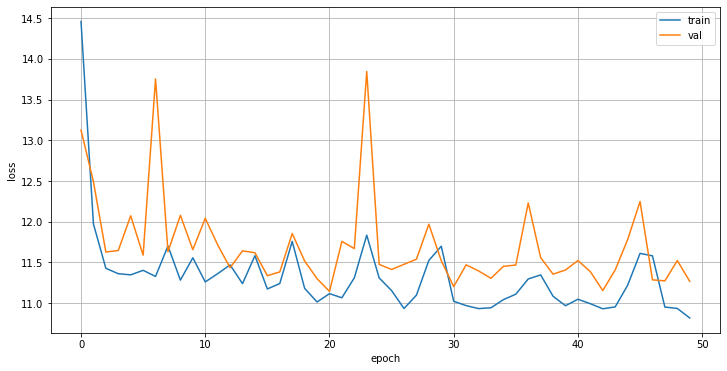

In [30]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.grid()
plt.show()